In [1]:
using QuickPOMDPs
using POMDPs
using POMDPTools
using Distributions
using LinearAlgebra
using MCTS
using POMDPSimulators
using POMDPPolicies
#using POMDPTutorials
using POMDPModels
using POMDPModelTools
using Plots
using CSV
using Tables

### Define problem

*** Parameters

In [2]:
# Dimensions
max_progress = 5
max_power = 50
max_h2o = 50
max_o2 = 50
max_food = 50

# Uncertainties
p_mission_regression = 0.05
p_power_fail = 0.02
p_water_loss = 0.02
p_food_loss = 0.02
p_no_mission_progress = 0.05

# Resource consumption
consumed_power = -10 # generated
consumed_h2o = 1
consumed_o2 = 8
consumed_food = 9

9

In [3]:
# Define all possible states and actions (with constraints)
# [progress, power, h2o, o2, food]
indexed = LinearIndices((max_progress, max_power, max_h2o, max_o2, max_food))
states = 1:indexed[max_progress, max_power, max_h2o, max_o2, max_food]

basic_actions = [
      CartesianIndex(1, -1, 0, 0, 0), # make mission progress
      CartesianIndex(0, -1, 2, 0, 0), # make water 
      CartesianIndex(0, -2, -1, 1, 0), # make oxygen
      CartesianIndex(0, -1, -1, -1, 2), # make food
      CartesianIndex(0, 0, 0, 0, 0)
] # do nothing
consumed = CartesianIndex(0, consumed_power, consumed_h2o, consumed_o2, consumed_food)
actions = [action - consumed for action in basic_actions]

5-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, 9, -1, -8, -9)
 CartesianIndex(0, 9, 1, -8, -9)
 CartesianIndex(0, 8, -2, -7, -9)
 CartesianIndex(0, 9, -2, -9, -7)
 CartesianIndex(0, 10, -1, -8, -9)

### Reward, Transition

In [4]:
# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]

function outofbounds(state, action)
    for i in 1:length(state)
        if ((state[i] + action[i]) < 1 || (state[i] + action[i]) > state_maxes[i])
            return true
        end
    end
    return false
end

# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]
function clamp_state(state)
    for i in 1:length(state)
        state[i] = clamp(state[i], 1, state_maxes[i])
    end
    return state
end

clamp_state (generic function with 1 method)

In [23]:
function reward(s, a)
    svec = CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
    if svec[1] == max_progress
        r = 1000
    elseif outofbounds(svec, a) # If invalid action
        r = -1000000
    else
        r = -1
    end
    return r
end
#end    

reward (generic function with 1 method)

In [24]:
function transition(s, a)
    svec = CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
    svec = collect(Tuple(svec))
    a = collect(Tuple(a))
    if outofbounds(svec, a)
        if outofbounds(svec, a)
            svec[2] = max_power
        end
        spvec = svec
    else
        if outofbounds(svec, a)
            svec[2] = max_power
        end
        x = rand()
        if (x < p_no_mission_progress)
            spvec = svec # no progress
        elseif (x < (p_water_loss + p_no_mission_progress))
            svec[3] = 1 # lose all water
            spvec = svec + a
        elseif (x<(p_water_loss + p_power_fail + p_no_mission_progress))
            svec[2] = 1 # lose all energy
            spvec = svec + a
        elseif (x < (p_mission_regression + p_water_loss + p_power_fail + p_no_mission_progress) && svec[3] > 1)
            svec[1] = svec[1] - 1 # backwards progress mission
            spvec = svec + a
        else 
            spvec = svec + a
        end
    end
    spvec = CartesianIndex(Tuple(spvec))
    sp = indexed[spvec] #linear index
    return sp
end


transition (generic function with 1 method)

*** Simulate

In [27]:
#simulate

#initialize
sarsp = Imatrix = zeros(Int, 4, 1)

current_state = indexed[1, 20, 20, 20, 20] #initialstate(mission)

states = collect(Tuple(CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[current_state]))

# s a r s'
count = 0
while (current_state[1] != state_maxes[1] && count < 10000)
    ind_action = rand(1:5)
    a = actions[ind_action] #random action
    next_state = transition(current_state, a)
    r = reward(next_state, a)
    sarsp = hcat(sarsp, [current_state, ind_action, r, next_state])
    #print(sarsp[:, count+1])
    current_state = next_state
    count += 1
end

#delete first row again
sarsp = sarsp[:, 2:end]




4×10000 Matrix{Int64}:
 12117346   6392641    667437    667497  …    667497    667497    667497
        2         1         1         1            2         3         2
       -1  -1000000  -1000000  -1000000     -1000000  -1000000  -1000000
  6392641    667437    667497    667497       667497    667497    667497

In [30]:
#write to csv

# Specify the filename
filename = "data.csv"

# Write the matrix to the CSV file
CSV.write(filename, Tables.table(sarsp'), header = ["s", "a", "r", "s'"])

"data.csv"

In [10]:
#prepare to plot

mission = states[3,:]
resources_E = states[1, :]
resources_H2O = states[2,:]
resources_total = resources_E  + resources_H2O
goal = fill(mission[end], length(mission))
t = range(0, length=length(mission))
rewards_accumulation = cumsum(rewards)


UndefVarError: UndefVarError: `rewards` not defined

In [11]:
#plot Mission Progress over Resources
p1 = plot()
plot!(p1, mission, resources_total, marker=(:circle,5), arrow=true, arrowsize=0.1, legend=false)
vline!(p1, goal[1])
ylabel!("Resources")
xlabel!("Mission Progress")
ylims!(0.9, (state_dimensions[1] + state_dimensions[2] + 1))
xlims!(0.9, state_dimensions[3] + 0.5)

#savefig(p1, "Mission Progress VS Resources.pdf")

UndefVarError: UndefVarError: `state_dimensions` not defined

┌ Info: Saved animation to /var/folders/53/dkwtw9r94vvbm2k2b5khb0ch0000gn/T/jl_mlYxs1gXcl.gif
└ @ Plots /Users/Anna/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/53/dkwtw9r94vvbm2k2b5khb0ch0000gn/T/jl_mlYxs1gXcl.gif")
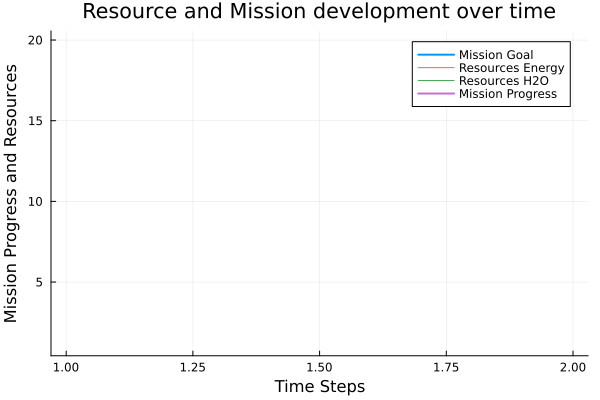

In [12]:
#plot Mission and Resource development over time
#savefig(p2, "Mission Progress VS Resources.pdf")
anim = @animate for i in 1:length(mission)
    p2 = plot()
    plot!(p2 , 1:i, goal[1:i],  linewidth=2,   label="Mission Goal")
    plot!(p2 ,1:i, [resources_E[1:i], resources_H2O[1:i]], label=["Resources Energy" "Resources H2O"], title = "Resource and Mission development over time")
    plot!(p2 ,1:i, mission[1:i], linewidth = 2,  label="Mission Progress")
    xlabel!("Time Steps")
    ylabel!("Mission Progress and Resources")
end


gif(anim, fps=5)

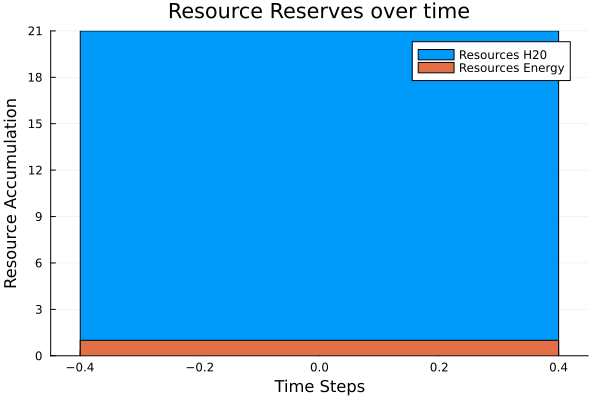

In [13]:
#Resource level histogram
p3 = bar(t, [resources_total, resources_E], xlabel="Time Steps", ylabel="Resource Accumulation", label=["Resources H20" "Resources Energy"], title = "Resource Reserves over time")

#savefig(p3, "Resource Reserves.pdf")

In [14]:
#Plot Reward accumulation over time
layout = @layout [a b] #creates 1x2 subplots

p4 = plot(t[1:end-1], rewards[1:end-1], subplot=1, layout=layout,legend=false)
plot!(p4, t, rewards_accumulation, subplot=2, legend=false)
xlabel!(p4, "Time Steps")
ylabel!(p4, "Rewards", subplot=1)
ylabel!(p4, "Accumulated Rewards", subplot=2)
title!(p4,"Rewards (except the \n last time step)", subplot = 1)
title!(p4,"Accumulated Rewards", subplot = 2)

#savefig(p4, "Rewards.pdf")

UndefVarError: UndefVarError: `rewards` not defined